In [1]:
%matplotlib inline

import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from sklearn.model_selection import train_test_split


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
np.random.seed(0)

In [2]:
n_epocs = 10000
epochs_per_stats = 1
batch_size = 1
test_size = 0.2
learning_rate = 0.002 * (batch_size / 1024.0)
momentum = 0.0

WORKING_DIR = '/home/richard/Downloads/nn/PSU_back/'

In [3]:
boards = torch.load('/home/richard/Downloads/connect4_boards.pth').numpy()
values = torch.load('/home/richard/Downloads/connect4_values.pth').numpy()

# Here we don't want to have the player to move channel
boards = boards[:, 1:]

board_train, board_test, value_train, value_test = train_test_split(boards, values, test_size=test_size, shuffle=True)

In [4]:
from connect4.neural.nn_pytorch import Connect4Dataset

train = Connect4Dataset(board_train, value_train)
test = Connect4Dataset(board_test, value_test)

train_gen = data.DataLoader(train, batch_size, shuffle=True)
# test_gen = data.DataLoader(test, 4096, shuffle=False)
test_gen = data.DataLoader(test, batch_size, shuffle=False)

In [ ]:
from connect4.neural.nn_pytorch import build_value_net

net = build_value_net() #value_head_fc_layers=16)

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.0000001)
    elif type(m) == nn.Conv2d:
        nn.init.normal_(m.weight, std=0.0000001)
    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, std=0.0000001)
#         nn.init.constant_(m.bias, 0)

# net.apply(init_normal)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (1): Sequential(
    (0): ResidualLayer(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): ResidualLayer(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0

In [ ]:
criterion = nn.MSELoss()
# criterion = nn.L1Loss()

# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(net.parameters())

In [ ]:
# option to load previous progress
# file_path = WORKING_DIR + '../nn9.pth'
file_path = None
if file_path is not None:
    checkpoint = torch.load()
    net.load_state_dict(checkpoint['net_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
from connect4.neural.stats import Stats

# Get an idea of how the initialisation is
def evaluate_fit(net, test_gen, device, output_stats=False):
    test_stats = Stats() if output_stats else None
    with torch.set_grad_enabled(False):
        net = net.eval()
        for board, value in test_gen:
            board, value = board.to(device), value.to(device)

            output = net(board)
            loss = criterion(output, value)

            if output_stats:
                output = output.cpu().numpy().flatten()
                value = value.cpu().numpy().flatten()
                test_stats.update(output, value, loss)
    return test_stats

test_stats = evaluate_fit(net, test_gen, device, True)
print("Initial Test Stats:\n", test_stats)

Initial Test Stats:
 Average loss:  0.24830  Accuracy:  0.09458  Smallest:  0.45195  Largest:  0.45346  Average:  0.45278
Category, # Members, # Correct Predictions:  (0.0, 3300, 0)  (0.5, 1278, 1278)  (1.0, 8934, 0)


Epoch:   0 
Train:
 Average loss:  0.09490  Accuracy:  0.72046  Smallest:  0.00005  Largest:  1.00000  Average:  0.70612
Category, # Members, # Correct Predictions:  (0.0, 13335, 6986)  (0.5, 5171, 1950)  (1.0, 35539, 30001) 
Test:
 Average loss:  0.07779  Accuracy:  0.74260  Smallest:  0.00204  Largest:  0.99979  Average:  0.68071
Category, # Members, # Correct Predictions:  (0.0, 3300, 1905)  (0.5, 1278, 675)  (1.0, 8934, 7454)


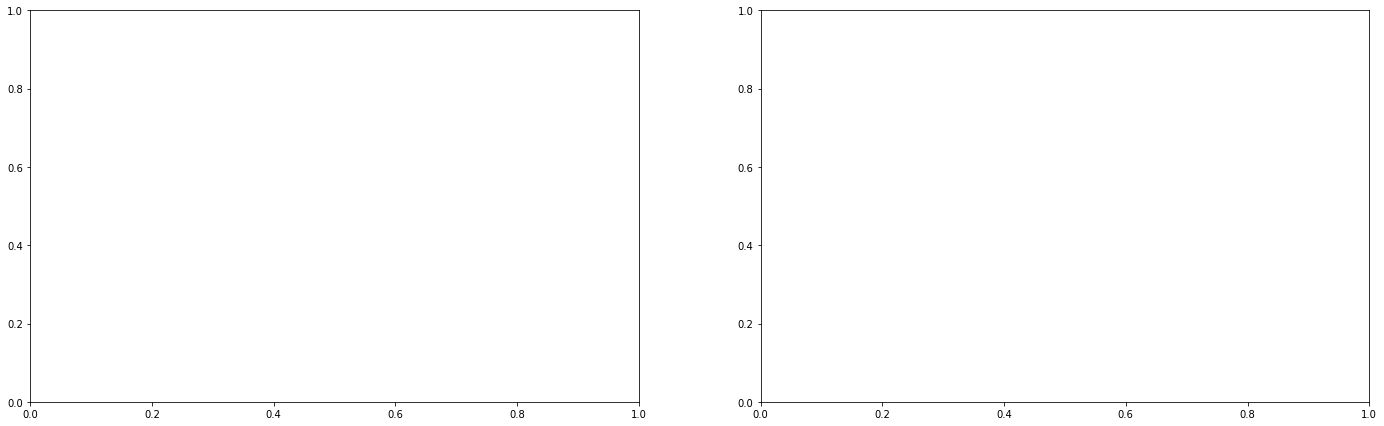

In [ ]:
%%time

from laplotter import LossAccPlotter
from visdom import Visdom

viz = Visdom()
plotter = LossAccPlotter()

for epoch in range(n_epocs):
    
    net = net.train()
    train_stats = Stats()
    
    for board, value in train_gen:
        board, value = board.to(device), value.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(board)
        loss = criterion(output, value)
        loss.backward()
        optimizer.step()
        
        if epoch % epochs_per_stats == 0:
            output = output.cpu().view(-1).detach().numpy()
            value = value.cpu().view(-1).numpy()
            train_stats.update(output, value, loss)

    # validate
    test_stats = evaluate_fit(net, test_gen, device, epoch % epochs_per_stats == 0)
                
    if test_stats is not None:            
        print("Epoch:  ", epoch, "\nTrain:\n", train_stats, "\nTest:\n", test_stats)
        plotter.add_values(epoch,
                           loss_train=train_stats.loss, acc_train=train_stats.accuracy,
                           loss_val=test_stats.loss, acc_val=test_stats.accuracy)
        if epoch == 0:
            win = viz.matplot(plotter.fig)
        else:
            viz.matplot(plotter.fig, win=win)
        
    torch.save({
        'net_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()},
        WORKING_DIR + str(epoch) + '-' + str(batch_size) + '.pth')
            
print('Finished Training')

In [ ]:
plotter.fig